In [1]:
# install torchsummary
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple torchsummary

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
import torchaudio
from torch.utils.data import DataLoader
import pandas as pd
import os
from itertools import product
from collections import namedtuple
from collections import OrderedDict
from IPython.display import display,clear_output
import time
import json
from torchsummary import summary
import matplotlib.pyplot as plt

torch.set_printoptions(linewidth=120)

In [3]:
# Add a column to the alphabetical list of label styles in the label file in numeric format
# Test dataset
ANNOTATIONS_FILE = "/kaggle/input/projectdataset/GTZAN_TEST/GTZAN_TEST/features_30_sec_test.csv"
dataframe = pd.read_csv(ANNOTATIONS_FILE)

labels = set()
for row in range(len(dataframe)):
    labels.add(dataframe.iloc[row, -1])
labels_list = []
for label in labels:
    labels_list.append(label)
sorted_labels = sorted(labels_list)
sorted_labels
mapping = {}
for index, label in enumerate(sorted_labels):
    mapping[label] = index
dataframe["num_label"] = dataframe["label"]
new_dataframe = dataframe.replace({"num_label": mapping})
new_dataframe

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label,num_label
0,blues.00080.wav,661794,0.368245,0.087909,0.242466,0.007511,1827.208500,155323.69940,1898.679905,55241.07013,...,-9.068514,48.603558,-2.030223,44.913212,-5.418258,54.039116,0.028647,49.168678,blues,0
1,blues.00081.wav,661794,0.380135,0.080725,0.248218,0.005397,2116.917659,95000.31886,1956.415912,45002.86672,...,-6.822724,48.155521,0.967809,43.657452,-7.566149,51.184902,2.920274,39.106922,blues,0
2,blues.00082.wav,661794,0.339175,0.086656,0.251406,0.003724,2141.518182,127242.45730,2168.297080,74578.88493,...,-9.472966,81.943733,1.933659,70.201164,-6.327237,57.190121,-1.304214,61.887894,blues,0
3,blues.00083.wav,661794,0.427291,0.080122,0.251242,0.003459,2314.927762,143909.62930,2261.811875,30962.56564,...,-4.049325,47.890514,3.256568,53.179390,-3.465543,38.221546,2.379480,60.413731,blues,0
4,blues.00084.wav,661794,0.396144,0.085204,0.235248,0.007127,2060.750291,229497.29800,2084.838437,81975.71652,...,-6.740202,45.364784,2.656939,55.688828,-4.384609,47.885178,0.412821,61.150539,blues,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.68920,2106.541053,88609.74951,...,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock,9
196,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.70950,2068.942009,82426.01673,...,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock,9
197,rock.00097.wav,661794,0.432142,0.075269,0.081651,0.000322,2077.526598,231657.96800,1927.293153,74717.12439,...,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock,9
198,rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.73110,1818.450280,109090.20720,...,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock,9


In [4]:
new_dataframe.to_csv("features_30_sec_test_final.csv")

In [5]:
# Training dataset
import pandas as pd
ANNOTATIONS_FILE = "/kaggle/input/projectdataset/GTZAN/GTZAN/features_30_sec.csv"
dataframe = pd.read_csv(ANNOTATIONS_FILE)
labels = set()
for row in range(len(dataframe)):
    labels.add(dataframe.iloc[row, -1])
labels_list = []
for label in labels:
    labels_list.append(label)
sorted_labels = sorted(labels_list)
mapping = {}
for index, label in enumerate(sorted_labels):
    mapping[label] = index
dataframe["num_label"] = dataframe["label"]
new_dataframe = dataframe.replace({"num_label": mapping})
new_dataframe

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label,num_label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.0645,2002.449060,85882.76132,...,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues,0
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.0736,2039.036516,213843.75550,...,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues,0
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.6434,1747.702312,76254.19226,...,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues,0
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.9424,1596.412872,166441.49480,...,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues,0
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.9393,1748.172116,88445.20904,...,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,rock.00075.wav,661794,0.408594,0.090618,0.126935,0.001782,2301.799132,411284.9049,2355.239840,76150.31095,...,-8.456369,52.968510,0.388519,57.249142,-9.238386,68.606178,-0.288135,78.638748,rock,9
796,rock.00076.wav,661794,0.345583,0.093378,0.145840,0.002309,1659.579361,508721.7777,1953.259408,113790.22220,...,-8.116253,55.894871,-0.675326,47.441017,-7.607761,46.765530,-0.208633,75.962044,rock,9
797,rock.00077.wav,661794,0.455317,0.077491,0.128746,0.001910,2187.977477,238379.0735,2350.874065,86250.32601,...,-6.241045,47.203609,-1.461478,57.166630,-8.244150,39.823624,-3.277006,31.328596,rock,9
798,rock.00078.wav,661794,0.358062,0.091999,0.144420,0.002087,1878.549952,521514.4318,2204.936033,137103.36440,...,-12.770678,34.306484,-4.898369,52.004292,-2.520796,68.188065,-3.129907,50.047249,rock,9


In [6]:
new_dataframe.to_csv("features_30_sec_final.csv")

In [7]:
# RunBuild class to manage hyperparameters, which can be automatically combined 
# during the training process for predefined hyperparameters
class RunBuilder():
    @staticmethod
    def get_runs(params):
        Run = namedtuple('Run', params.keys())
        
        runs = []
        
        for element in product(*params.values()):
            runs.append(Run(*element))
        
        return runs

In [8]:
# Runtime data management classes
class RunManager():
    def __init__(self):
        #Training set
        # Number of epoches
        self.epoch_count = 0
        # Loss value per epoch
        self.epoch_loss = 0
        # Number of correct predictions per epoch
        self.epoch_correct_num = 0
        # Start time of training per epoch
        self.epoch_start_time = None
        
        # Test dataset
        self.test_epoch_count = 0
        self.test_epoch_loss = 0
        self.test_epoch_correct_num = 0
        
        
        # Hyperparameters of each run, number of cycles, etc.
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None
        
        
        self.network = None
        self.loader = None
        # tensorboard
        self.tb = None
    
    def begin_run(self, run, network, loader, test_loader):
        # Initial start time
        self.run_start_time = time.time()
        # Initialising hyperparameters
        self.run_params = run
        # run times +1
        self.run_count += 1
        
        self.network = network
        self.loader = loader
        self.test_loader = test_loader
        # Load tensorboard
        self.tb = SummaryWriter(comment=f'-{run}')
        
        # signal: sampling signal sr: sampling frequency
        signal, sr, address = next(iter(self.loader))
        
        
        # Signal conversion to mel-spectrum is missing here, no image visualisation added yet
        
        # Neural network structure image visualisation
        self.tb.add_graph(
            self.network,
            signal.to(run.device)
        )
        
    def end_run(self):
        # Close tensorboard to write data
        self.tb.close()
        # Each epoch is re-counted again
        self.epoch_count = 0
        self.test_epoch_count = 0
        
    def begin_epoch(self):
        self.epoch_start_time = time.time()
        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_correct_num = 0
        
        self.test_epoch_count += 1
        self.test_epoch_loss = 0
        self.test_epoch_correct_num = 0
        
    def end_epoch(self):
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time

        # Training set loss values
        loss = self.epoch_loss / len(self.loader.dataset)
        # Test set Accuracy Rate
        accuracy = self.epoch_correct_num / len(self.loader.dataset)
        print(f'accuracy rate：{self.epoch_correct_num} / {len(self.loader.dataset)}')
        
        # Test set
        # print(f"{self.test_epoch_correct_num}+{len(self.test_loader.dataset)}")
        test_loss = self.test_epoch_loss / len(self.test_loader.dataset)
        test_accuracy = self.test_epoch_correct_num / len(self.test_loader.dataset)
        
        # Add the loss function image
        self.tb.add_scalars('Loss', {"train_loss": loss, 
                                    "test_loss": test_loss}, self.epoch_count)
        # Add an image of the accuracy function
        self.tb.add_scalars('Accuracy', {"train_accuracy": accuracy, 
                                        "test_accuracy": test_accuracy}, self.epoch_count)
        
        # self.tb.add_scalar('Test_Loss', test_loss, self.epoch_count)
        
        #self.tb.add_scalar('Test_Accuracy', test_accuracy, self.epoch_count)
        
        for name, param in self.network.named_parameters():
            # The value of each layer of the neural network
            self.tb.add_histogram(name, param, self.epoch_count)
            # Gradient corresponding to each layer value
            self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)

        results = OrderedDict()

        results['run'] = self.run_count
        results['epoch'] = self.epoch_count
        results['loss'] = loss
        results['accuracy'] = accuracy
        results['epoch duration'] = epoch_duration
        results['run duration'] = run_duration

        for k, v in self.run_params._asdict().items():
            results[k] = v

        self.run_data.append(results)

        df = pd.DataFrame.from_dict(self.run_data, orient='columns')

        clear_output(wait = True)
        display(df)
        
    # def test_view(self):
        
    # Core number
    def get_num_workers(self,num_workers):
        self.epoch_num_workers = num_workers

    # Training set 
    # Record the loss of each epoch. Training set    
    def track_loss(self,loss,batch):
        self.epoch_loss += loss.item()*batch[0].shape[0]
    
    # Test set
    def test_loss(self,test_loss, test_batch):
         self.test_epoch_loss += test_loss.item()*test_batch[0].shape[0]
    
    # Record the number of correct tests on each epoch
    def test_num_correct(self, test_preds, test_labels):
        
        self.test_epoch_correct_num += self.get_correct_num(test_preds, test_labels)
        
    # Training set
    def track_num_correct(self, preds, labels):
        self.epoch_correct_num += self.get_correct_num(preds, labels)
    
    def get_correct_num(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    # Training data saved in CSV file
    def save(self, fileName):
        pd.DataFrame.from_dict(
            self.run_data, orient='columns'
        ).to_csv(f'{fileName}.csv')
        
        with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

Using cuda device


/opt/conda/lib/python3.7/site-packages/torchaudio/functional/functional.py:508: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


There are 800 samples in the dataset
path:/kaggle/input/projectdataset/GTZAN/GTZAN/genres_original/reggae/reggae.00026.wav
torch.Size([1, 40, 552])


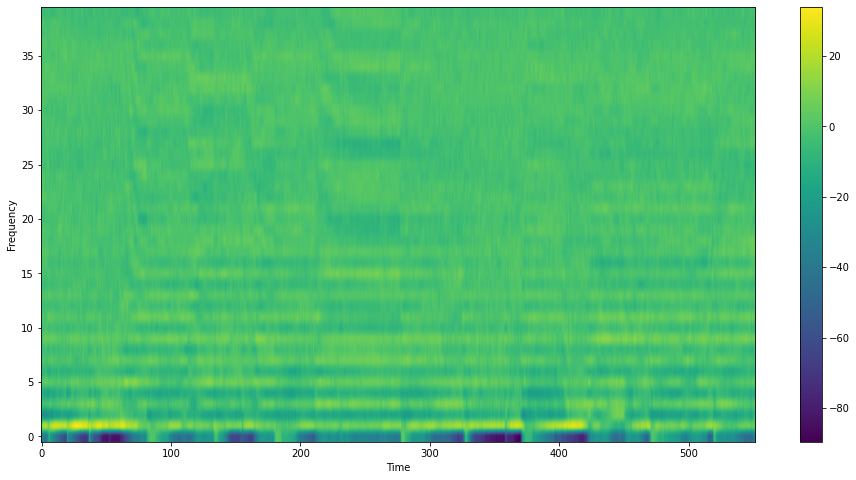

In [9]:
# Data pre-processing classes

class GTZANDataset(Dataset):
    def __init__(self,
                 annotations_file,
                 audio_dir,
                 transformation,
                 target_sample_rate,
                 num_samples,
                 device):
        # Read the label file
        self.annotations = pd.read_csv(annotations_file)
        # Reading audio addresses
        self.audio_dir = audio_dir
        # Set the device
        self.device = device
        # loaded into the deviceLoading Mel spectrum data into the device
        self.transformation = transformation.to(self.device)
        # Setting sampling frequency
        self.target_sample_rate = target_sample_rate
        # Set number of samples
        self.num_samples = num_samples
        
        
    # Returns the number of audio files
    def __len__(self):
        return len(self.annotations)

    
    # Get data, tags, paths for audio
    def __getitem__(self, index):
        # Get the song path
        audio_sample_path = self._get_audio_sample_path(index)
        # Get the label
        label = self._get_audio_sample_label(index)
        # signal: sampling signal sr: sampling frequency
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        # Control sampling frequency
        signal = self._resample_if_necessary(signal, sr)
        # Dual channel->single channel
        signal = self._mix_down_if_necessary(signal)
        # Control the number of samples
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        # Transforming the mel spectrum
        signal = self.transformation(signal)
        return signal, label, audio_sample_path

    
    # Whether the signal needs to be cropped. 
    # If the number of picks > the set number -> crop.
    def _cut_if_necessary(self, signal):
        # print('_cut_if_necessary')
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal
    
    
    # Whether the signal needs to be replenished. Fill in 0 to the right to replenish,
    # If the number of picks < the set number -> replenish
    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        # print('_right_pad_if_necessary')
        if length_signal < self.num_samples:
            
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            # last_dim_padding.to(self.device)
            
            signal = torch.nn.functional.pad(signal, last_dim_padding)

        return signal

    
    # Resetting the sampling frequency
    def _resample_if_necessary(self, signal, sr):
        # print('_resample_if_necessary')
        # If the actual sampling frequency does not match the setting -> reset it
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate).to(self.device)
            signal = resampler(signal)
            # signal = torchaudio.functional.resample(signal, sr, self.target_sample_rate)
            
        return signal


    # Changing the audio from dual channel to single channel
    def _mix_down_if_necessary(self, signal):
        # print('_mix_down_if_necessary')
        
        # If the number of channels is greater than 1 ->
        # take the average value and turn it into a single channel
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    # Splicing and extraction of audio paths
    def _get_audio_sample_path(self, index):
        # print('_get_audio_sample_path')
        fold = f"{self.annotations.iloc[index, -2]}"
        path = os.path.join(self.audio_dir, fold, self.annotations.iloc[
            index, 1])
        return path
    
    
    # Extracting labels from csv files
    def _get_audio_sample_label(self, index):
        # print('_get_audio_sample_label')
        return self.annotations.iloc[index, -1]
    

if __name__ == "__main__":
    ANNOTATIONS_FILE = "./features_30_sec_final.csv"
    AUDIO_DIR = "/kaggle/input/projectdataset/GTZAN/GTZAN/genres_original"
    SAMPLE_RATE = 22050
    NUM_SAMPLES = 22050 * 5 # -> 1 second of audio
    plot = True

    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using {device} device")

    mfcc = torchaudio.transforms.MFCC(
        sample_rate=SAMPLE_RATE,
        n_mfcc=40,
        log_mels=True
    )

    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        # Windows size
        hop_length=512,
        # Mel Frequency
        n_mels=64
    )

    # objects inside transforms module are callable!
    # ms = mel_spectrogram(signal)

    gtzan = GTZANDataset(
        ANNOTATIONS_FILE,
        AUDIO_DIR,
        mfcc,
        SAMPLE_RATE,
        NUM_SAMPLES,
        device
    )

    print(f"There are {len(gtzan)} samples in the dataset")

    if plot:
        signal, label, path = gtzan[666]
        print(f'path:{path}')
        signal = signal.cpu()
        print(signal.shape)
        
        plt.figure(figsize=(16, 8), facecolor="white")
        plt.imshow(signal[0,:,:], origin='lower')
        plt.autoscale(False)
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.colorbar()
        plt.axis('auto')
        plt.show()


In [10]:
ANNOTATIONS_FILE = "./features_30_sec_final.csv"
AUDIO_DIR = "/kaggle/input/projectdataset/GTZAN/GTZAN/genres_original"
SAMPLE_RATE = 22050
NUM_SAMPLES = 22050  * 5

# These next three functions don't actually do anything later and can be removed
# Creating a data loading set
def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True,num_workers=0, pin_memory=True)
    return train_dataloader


# Training for each epoch
def train_single_epoch(model, data_loader, loss_fn, optimiser, device):
    for input, target in data_loader:
        input, target = input.to(device), target.to(device)

        # calculate loss
        prediction = model(input)
        loss = loss_fn(prediction, target)

        # backpropagate error and update weights
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    print(f"loss: {loss.item()}")

# Training
def train(model, data_loader, loss_fn, optimiser, device, epochs):
    for i in range(epochs):
        print(f"Epoch {i+1}")
        train_single_epoch(model, data_loader, loss_fn, optimiser, device)
        print("---------------------------")
    print("Finished training")

In [11]:
# AlexNet network
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            # Convolution
            # Input channel 1, output channel 64 Convolution kernel size 11*11 
            # Step size 4 Zero padding 2
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            # ReLU activation function
            nn.ReLU(inplace=True),
            # Maximum pooling
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # Flat
        self.flatten = nn.Flatten()
        # Classifier
        self.classifier = nn.Sequential(
            # Linear classifier Fully connected layer
            nn.Linear(12288, 1024),
            nn.ReLU(inplace=True),
            # Dropout Random inactivation
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3, inplace=False),
            nn.Linear(1024, num_classes),
        )
    # Forward transmission
    def forward(self, x):
        x = self.features(x)
        #x = x.view(-1, 3072)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [12]:
if __name__ == '__main__':
    from torchsummary import summary
    alex=AlexNet().to("cuda")
    summary(alex, (1, 128, 111* 5))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 31, 138]           7,808
              ReLU-2          [-1, 64, 31, 138]               0
         MaxPool2d-3           [-1, 64, 15, 68]               0
            Conv2d-4          [-1, 192, 15, 68]         307,392
              ReLU-5          [-1, 192, 15, 68]               0
         MaxPool2d-6           [-1, 192, 7, 33]               0
            Conv2d-7           [-1, 384, 7, 33]         663,936
              ReLU-8           [-1, 384, 7, 33]               0
            Conv2d-9           [-1, 256, 7, 33]         884,992
             ReLU-10           [-1, 256, 7, 33]               0
           Conv2d-11           [-1, 256, 7, 33]         590,080
             ReLU-12           [-1, 256, 7, 33]               0
        MaxPool2d-13           [-1, 256, 3, 16]               0
          Flatten-14                [-1

In [13]:
torch.manual_seed(128)

In [14]:
# Defining the dictionary of hyperparameters
params = OrderedDict(
    lr = [.001, .0001]
    , batch_size = [64]
    , num_workers = [0]
    , device = ['cuda']
    
)

# Training set label file address
ANNOTATIONS_FILE = "./features_30_sec_final.csv"
# Training set audio file address
AUDIO_DIR = "/kaggle/input/projectdataset/GTZAN/GTZAN/genres_original"

# Test set
ANNOTATIONS_FILE_TEST = "./features_30_sec_test_final.csv"
AUDIO_DIR_TEST = "/kaggle/input/projectdataset/GTZAN_TEST/GTZAN_TEST/genres_original"

In [15]:
# Did not use this.
mfcc = torchaudio.transforms.MFCC(
        sample_rate=SAMPLE_RATE,
        n_mfcc=128,
        log_mels=True
)

# Mel spectrum conversion
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)





m = RunManager()
# c = 0
# acc = 0
# now_acc = 0
# Here's the real training
for run in RunBuilder.get_runs(params):
    usd = GTZANDataset(ANNOTATIONS_FILE,
                        AUDIO_DIR,
                        mfcc,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        run.device)
    usd_test = GTZANDataset(
        ANNOTATIONS_FILE_TEST,
        AUDIO_DIR_TEST,
        mfcc,
        SAMPLE_RATE,
        NUM_SAMPLES,
        run.device
    )
    
    print(run)
    device = torch.device(run.device)
    
#     train_dataloader = create_data_loader(usd,
#                                          batch_size = run.batch_size,
#                                          num_workers = run.num_workers)
    
    train_data_loader = DataLoader(usd, batch_size=run.batch_size, num_workers = run.num_workers, shuffle=True)
    
    test_data_loader = DataLoader(usd_test, batch_size=run.batch_size,num_workers = run.num_workers)
    
    # network = VGG16().to(device)
    # network = CNNNetwork().to(device)
    # network = ANNNet().to(device)
    network = AlexNet().to(device)
    print(network)
    # Optimizer
    optimizer = optim.Adam(network.parameters(),lr=run.lr)
    m.begin_run(run, network, train_data_loader, test_data_loader)
    #best_loss Initialised to +∞.
    best_loss = float('inf')
    for epoch in range(100):
        network.train()
        m.begin_epoch()
        for batch in train_data_loader:
            input = batch[0].to(device)
            target = batch[1].to(device)
            preds = network(input)
            loss = F.cross_entropy(preds,target)
            optimizer.zero_grad()
            # Reverse transmission
            loss.backward()
            optimizer.step()
            m.track_loss(loss, batch)
            m.track_num_correct(preds, target)
                    
        with torch.no_grad():
            # This part is used for testing, so it does not calculate the gradient
            for test_batch in test_data_loader:
                test_input = batch[0].to(device)
                test_target = batch[1].to(device)
                test_preds = network(test_input)
                test_loss = F.cross_entropy(test_preds,test_target)

                m.test_loss(test_loss, test_batch)
                
                m.test_num_correct(test_preds, test_target)    
        m.end_epoch()
        
    # Save the model   
    torch.save(network.state_dict(), f'best_model_okk.pth')
    m.end_run()
    m.save(f'{run.lr}_{run.batch_size}')

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,num_workers,device
0,1,1,2.789009,0.10250,27.973186,37.217320,0.0010,64,0,cuda
1,1,2,2.274814,0.12500,8.890897,48.367909,0.0010,64,0,cuda
2,1,3,2.304163,0.10125,8.831173,59.764059,0.0010,64,0,cuda
3,1,4,2.294381,0.10875,8.780438,70.802489,0.0010,64,0,cuda
4,1,5,2.235770,0.17500,9.158571,82.224477,0.0010,64,0,cuda
...,...,...,...,...,...,...,...,...,...,...
195,2,96,0.088002,0.96750,8.624242,1122.868991,0.0001,64,0,cuda
196,2,97,0.047967,0.98250,8.759393,1134.179528,0.0001,64,0,cuda
197,2,98,0.053149,0.98500,8.827622,1145.906610,0.0001,64,0,cuda
198,2,99,0.028846,0.99375,8.744203,1157.279763,0.0001,64,0,cuda


In [16]:
!zip -r runs.zip runs


  adding: runs/ (stored 0%)
  adding: runs/Jan08_14-28-15_f5f5715687ac-Run(lr=0.001, batch_size=64, num_workers=0, device='cuda')/ (stored 0%)
  adding: runs/Jan08_14-28-15_f5f5715687ac-Run(lr=0.001, batch_size=64, num_workers=0, device='cuda')/events.out.tfevents.1673188100.f5f5715687ac.23.0 (deflated 94%)
  adding: runs/Jan08_14-28-15_f5f5715687ac-Run(lr=0.001, batch_size=64, num_workers=0, device='cuda')/Loss_train_loss/ (stored 0%)
  adding: runs/Jan08_14-28-15_f5f5715687ac-Run(lr=0.001, batch_size=64, num_workers=0, device='cuda')/Loss_train_loss/events.out.tfevents.1673188132.f5f5715687ac.23.1 (deflated 57%)
  adding: runs/Jan08_14-28-15_f5f5715687ac-Run(lr=0.001, batch_size=64, num_workers=0, device='cuda')/Accuracy_test_accuracy/ (stored 0%)
  adding: runs/Jan08_14-28-15_f5f5715687ac-Run(lr=0.001, batch_size=64, num_workers=0, device='cuda')/Accuracy_test_accuracy/events.out.tfevents.1673188132.f5f5715687ac.23.4 (deflated 64%)
  adding: runs/Jan08_14-28-15_f5f5715687ac-Run(lr=0

In [17]:
!rm -rf runs

!rm -rf "runs.zip"

In [18]:
class_mapping = [
    'blues',
    'classical',
    'country',
    'disco',
    'hiphop',
    'jazz',
    'metal',
    'pop',
    'reggae',
    'rock'
]

In [19]:
import random

ran = random.sample(range(0,1000),10)
ran 

[250, 50, 572, 52, 110, 767, 853, 873, 861, 560]

In [20]:
# X: tensor of the input mel spectrum, y: actual label subscript, 
# class_mapping: label dictionary
def predict(model, X, y, class_mapping):
    model.eval()    # train <-> eval: changes how model behave (e.g. no dropout, ...)
    with torch.no_grad():
        predictions = model(X)
        # tensor (1, 10) -> [ [0.1, 0.04, ..., 0.6] ]
        # Fetch the largest output subscript
        predicted_index = predictions[0].argmax(0)
        # Prediction labels
        predicted = class_mapping[predicted_index]
        # The actual label
        expected = class_mapping[y]
        
    return predicted, expected

In [21]:
# Test accuracy of test sets
def verify_acc(local):
    
    # load back the model
    #cnn = CNNNetwork()
    #cnn = VGG16()
    cnn = AlexNet()
    #cnn = ANNNet()
    state_dict = torch.load(local)
    cnn.load_state_dict(state_dict)

    # load gtzan validation dataset
    mfcc = torchaudio.transforms.MFCC(
        sample_rate=SAMPLE_RATE,
        n_mfcc=128,
        log_mels=True
    )

    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )

    gtzan = GTZANDataset(
        annotations_file=ANNOTATIONS_FILE,
        audio_dir=AUDIO_DIR,
        transformation=mfcc,
        target_sample_rate=SAMPLE_RATE,
        num_samples=NUM_SAMPLES,
        device="cpu"
    )

    count = 0
    for i in range(0,800):
        index = i

        # get a sample from the gtzan dataset for inference
        X, y = gtzan[index][0], gtzan[index][1] # [batch_size, num_channels, freq, time]
        X.unsqueeze_(0) # insert an extra dimension at index 0
        #print(X.shape)
        #print(y)

        # make an inference
        predicted, expected = predict(cnn, X, y, class_mapping)
        #print(f"Predicted: {predicted}")
        #print(f"Expected: {expected}")
        if predicted == expected:
            
            count += 1
            #print(count)
    print(count/800.00)
    return (count/800.00) 
acc = verify_acc("best_model_okk.pth")
acc        
#         print(f"Predicted: {predicted}")
#         print(f"Expected: {expected}")
        

/opt/conda/lib/python3.7/site-packages/torchaudio/functional/functional.py:508: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


0.9975


0.9975

In [22]:
import random
cnn = AlexNet()
state_dict = torch.load("best_model_okk.pth")
cnn.load_state_dict(state_dict)
mfcc = torchaudio.transforms.MFCC(
        sample_rate=SAMPLE_RATE,
        n_mfcc=128,
        log_mels=True
)

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)

gtzan = GTZANDataset(
    annotations_file=ANNOTATIONS_FILE,
    audio_dir=AUDIO_DIR,
    transformation=mfcc,
    target_sample_rate=SAMPLE_RATE,
    num_samples=NUM_SAMPLES,
    device="cpu"
)




cnn.eval()

initial = random.sample(range(0,800),1)[0]
print(f'initial:{initial}')

music_init_index = gtzan[initial][1]
music_init_url = gtzan[initial][2]

print(f'music_init:{music_init_url}')


ran = random.sample(range(0,800),15)

max_music_value = - float("inf")
max_music_index = None
max_music_url = None
real_label_index = None

content={}
for i in range(15):
    with torch.no_grad():
        predictions = cnn(gtzan[ran[i]][0].unsqueeze_(0))
        predicted_item = predictions[0][music_init_index].item()
        if max_music_value < predicted_item:
            max_music_value = predicted_item
            max_music_index = i
            real_label_index = gtzan[ran[i]][1]
            max_music_url = gtzan[ran[i]][2]
        content[gtzan[ran[i]][2]] = predicted_item


initial:548
music_init:/kaggle/input/projectdataset/GTZAN/GTZAN/genres_original/metal/metal.00068.wav


In [23]:
class_mapping[music_init_index]


'metal'

In [24]:
content

{'/kaggle/input/projectdataset/GTZAN/GTZAN/genres_original/classical/classical.00062.wav': -4.725441932678223,
 '/kaggle/input/projectdataset/GTZAN/GTZAN/genres_original/classical/classical.00039.wav': -9.026894569396973,
 '/kaggle/input/projectdataset/GTZAN/GTZAN/genres_original/metal/metal.00048.wav': 23.010581970214844,
 '/kaggle/input/projectdataset/GTZAN/GTZAN/genres_original/rock/rock.00037.wav': -1.4725898504257202,
 '/kaggle/input/projectdataset/GTZAN/GTZAN/genres_original/reggae/reggae.00011.wav': -8.724170684814453,
 '/kaggle/input/projectdataset/GTZAN/GTZAN/genres_original/blues/blues.00077.wav': -0.06093236804008484,
 '/kaggle/input/projectdataset/GTZAN/GTZAN/genres_original/rock/rock.00029.wav': -2.1974830627441406,
 '/kaggle/input/projectdataset/GTZAN/GTZAN/genres_original/hiphop/hiphop.00054.wav': -3.0064315795898438,
 '/kaggle/input/projectdataset/GTZAN/GTZAN/genres_original/blues/blues.00064.wav': 1.599802851676941,
 '/kaggle/input/projectdataset/GTZAN/GTZAN/genres_ori

In [25]:
max_music_value

41.31804275512695

In [26]:
max_music_index

14

In [27]:
real_label_index

6

In [28]:
class_mapping[real_label_index]

'metal'

In [29]:
max_music_url

'/kaggle/input/projectdataset/GTZAN/GTZAN/genres_original/metal/metal.00014.wav'

In [30]:
ran = random.sample(range(0,1000),10)
for i in range(10):
    print(ran[i])

513
106
977
388
901
954
578
906
772
808
